In [1]:
%load_ext autoreload
%autoreload 2
from glob import glob
import os
from pathlib import Path
import re
import sys
import yaml
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from func.utils import get_categorical_features, read_pkl_gzip, to_pkl_gzip, parallel_load_data, get_filename, logger_func
from ieee_train import eval_train, eval_check_feature
from kaggle_utils import reduce_mem_usage, move_feature
logger = logger_func()

2019-09-13 21:09:55,093 func.utils 347 [INFO]    [logger_func] start 


In [2]:
COLUMN_ID = 'TransactionID'
COLUMN_DT = 'TransactionDT'
COLUMN_TARGET = 'isFraud'
COLUMN_GROUP = 'DT-M'
COLUMNS_IGNORE = [COLUMN_ID, COLUMN_DT, COLUMN_TARGET, COLUMN_GROUP, 'is_train', 'date']

def filter_feature(path):
    if path.count(''):
        return True
    else:
        return False

paths_train = glob('../feature/raw_use/*_train.gz')
paths_train = [path for path in paths_train if filter_feature(path) ]
paths_test = glob('../feature/raw_use/*_test.gz')
paths_test = [path for path in paths_test if filter_feature(path) ]

paths_train_feature = sorted(glob('../feature/org_use/*_train.gz'))
paths_test_feature  = sorted(glob('../feature/org_use/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/kernel/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/kernel/*_test.gz'))

# paths_train_feature += sorted(glob('../feature/valid_use/*_train.gz'))
# paths_test_feature  += sorted(glob('../feature/valid_use/*_test.gz'))

# df_train = reduce_mem_usage( parallel_load_data(paths_train) )
# df_test  = reduce_mem_usage( parallel_load_data(paths_test) )
df_train = parallel_load_data(paths_train)
df_test  = parallel_load_data(paths_test)
Y = df_train[COLUMN_TARGET]
df_train.drop(COLUMN_TARGET, axis=1, inplace=True)

  4%|▍         | 4/103 [00:00<00:02, 36.65it/s]

* Check Unique Feature.


100%|██████████| 103/103 [00:01<00:00, 67.00it/s]


All Features have info.
  * Diff Features: 0
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[147]	valid_0's auc: 0.897603


2019-09-13 21:10:32,632 func.utils 111 [INFO]    [ieee_cv]   * Fold0 2017-12: 0.8976032923083302 


[  * Fold0 Validation-DT-M 2017-12: 134339] done in 16 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.932296
Early stopping, best iteration is:
[153]	valid_0's auc: 0.932448


2019-09-13 21:10:48,919 func.utils 111 [INFO]    [ieee_cv]   * Fold1 2018-3: 0.932447838702026 


[  * Fold1 Validation-DT-M 2018-3: 101968] done in 16 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.934712
Early stopping, best iteration is:
[311]	valid_0's auc: 0.936139


2019-09-13 21:11:15,719 func.utils 111 [INFO]    [ieee_cv]   * Fold2 2018-1: 0.9361385314756834 


[  * Fold2 Validation-DT-M 2018-1: 92510] done in 26 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[96]	valid_0's auc: 0.927556


2019-09-13 21:11:29,378 func.utils 111 [INFO]    [ieee_cv]   * Fold3 2018-5: 0.9275563055993852 


[  * Fold3 Validation-DT-M 2018-5: 92427] done in 13 s
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[132]	valid_0's auc: 0.944285


2019-09-13 21:11:44,718 func.utils 111 [INFO]    [ieee_cv]   * Fold4 2018-2: 0.9442854612270738 


[  * Fold4 Validation-DT-M 2018-2: 85725] done in 15 s
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's auc: 0.942643
Early stopping, best iteration is:
[166]	valid_0's auc: 0.943486


2019-09-13 21:12:01,972 func.utils 111 [INFO]    [ieee_cv]   * Fold5 2018-4: 0.9434856904777273 


[  * Fold5 Validation-DT-M 2018-4: 83571] done in 17 s
[  * Make Prediction Result File.] done in 56 s
* Check Corr with Past Submit.
  *  (506691,) (506691,)
  * LB0.9516 / 0.9171003480264392
  *  (506691,) (506691,)
  * LB0.95169 / 0.9465951142633591
  *  (506691,) (506691,)
  * LB0.9518 / 0.9579532904438797
  *  (506691,) (506691,)
  * LB0.9526 / 0.9424538423907705
* CV: 0.930252853298371 | BestIter: 167.5
* Training Feature Importance


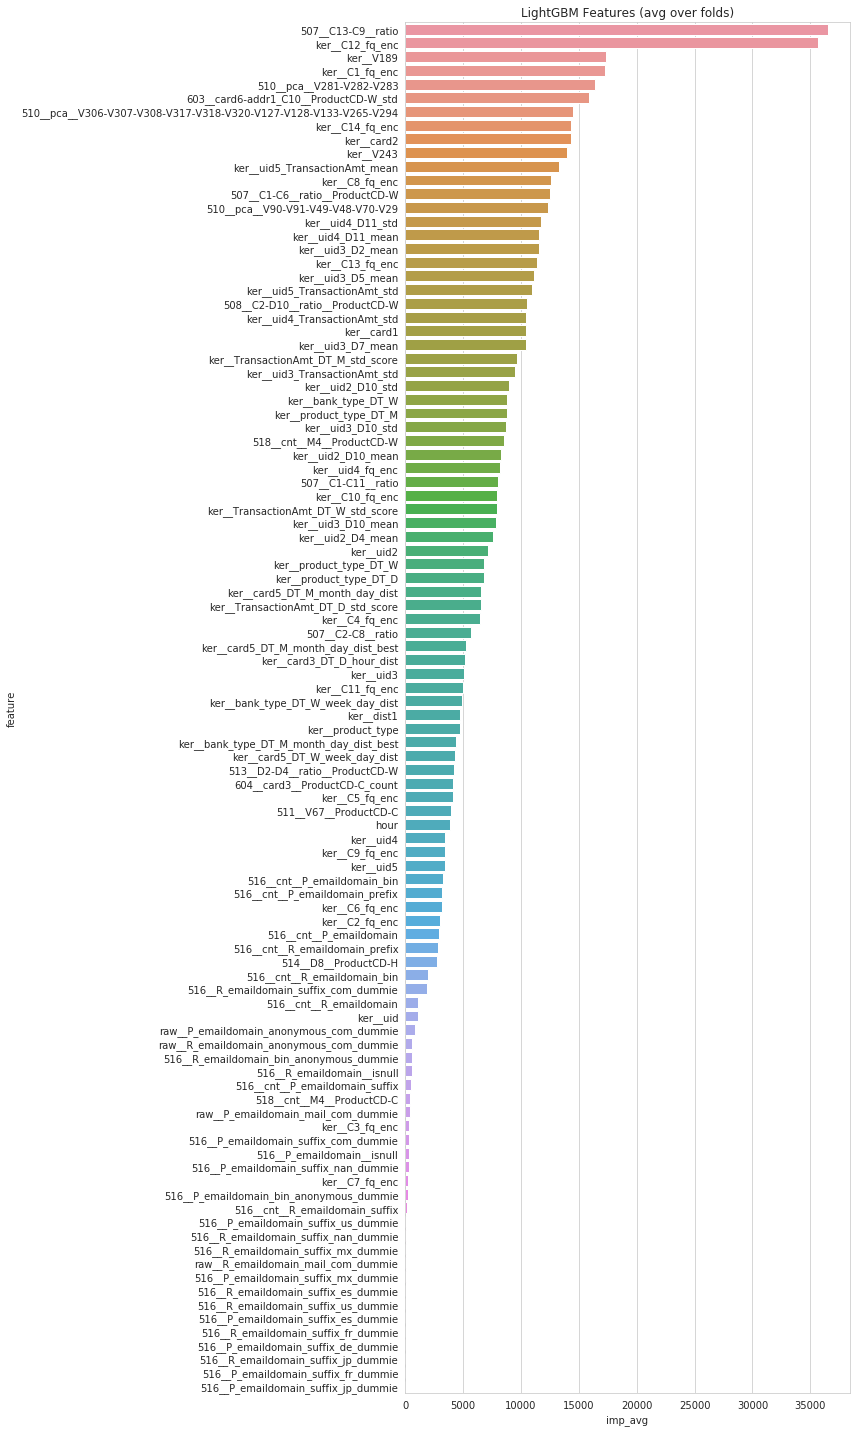

Setup Dataset dim_ml_dataset.


In [3]:
is_submit = [True, False][1]
valid_paths_train = paths_train_feature[:]
valid_paths_test  = paths_test_feature[:]

#========================================================================
# pathの存在チェック。なぜかたびたびFileNotFoundErrorが起きるので,,,
#========================================================================
remove_paths = []
for trn_path, tes_path in zip(valid_paths_train, valid_paths_test):
    if os.path.exists(trn_path) and os.path.exists(tes_path):
        pass
    else:
        remove_paths.append(trn_path)
        remove_paths.append(tes_path)
for path in remove_paths:
    if path.count('train'):
        valid_paths_train.remove(path)
        print(f'remove {path}')
    elif path.count('test'):
        valid_paths_test.remove(path)
        print(f'remove {path}')

df_feat_train = parallel_load_data(valid_paths_train)
df_feat_test  = parallel_load_data(valid_paths_test)

col_drops = eval_check_feature(df_feat_train, df_feat_test)

tmp_train = df_train.join(df_feat_train)
tmp_test = df_test.join(df_feat_test)

#========================================================================
# Train Test で片方に存在しないFeatureを除外
#========================================================================
diff_cols = list(set(tmp_train.columns) - set(tmp_test.columns))

for col in list(set(diff_cols)):
    from_dir = 'valid'
    to_dir = 'valid_trush'
    move_feature([col], from_dir, to_dir)
tmp_train.drop(diff_cols, axis=1, inplace=True)
print(f"  * Diff Features: {len(diff_cols)}")

# same_user_path = '../output/same_user_pattern/20190901_user_ids_share.csv'
# same_user_path = '../output/same_user_pattern/0902__same_user_id__card_addr_pemail_M.csv'
group_kfold_path = '../input/0908_ieee__DT-M_GroupKFold.gz'
group = read_pkl_gzip(group_kfold_path)
tmp_train[COLUMN_GROUP] = group


#========================================================================
# Features elimination 
#==============================================================
# from scipy.stats import ks_2samp
# features_check = []
# columns_to_check = set(list(tmp_train)).difference(COLUMNS_IGNORE)
# for i in columns_to_check:
#     features_check.append(ks_2samp(tmp_test[i], tmp_train[i])[1])

# features_check = pd.Series(features_check, index=columns_to_check).sort_values() 
# features_discard = list(features_check[features_check==0].index)
# print(features_discard)
# tmp_train.drop(features_discard, axis=1, inplace=True)
# tmp_test.drop(features_discard, axis=1, inplace=True)


model_type = "lgb"
params = {
#     'n_jobs': 64,
    'n_jobs': 32,
    'seed': 1208,
    'n_splits': 6,
    'metric': 'auc',
    'model_type': model_type,
    'objective': 'binary',
    'fold': ['stratified', 'group'][1],
    'num_leaves': 2**8-1,
    'max_depth': -1,
    'subsample': 0.9,
    'subsample_freq': 1,
    'colsample_bytree' : 0.50,
    'lambda_l1' : 0.1,
    'lambda_l2' : 1.0,
    'learning_rate' : 0.1,
    "early_stopping_rounds": 50,
}

if is_submit:
    params['learning_rate'] = 0.01
    params["early_stopping_rounds"] = 100

list_result_feim = eval_train(
    logger,
    tmp_train,
    Y,
    tmp_test,
    COLUMN_GROUP,
    model_type,
    params,
    is_adv=[True, False][1],
    is_viz=[True, False][0],
)

In [8]:
# feim = read_pkl_gzip('../output/feature_importances/20190912_0822__CV0-9456328818476605__feature726.gz')
# pd.set_option('max_rows', 200)
feim = list_result_feim[0]
# idx = [idx for idx in feim.index if idx.count('522_')]
# feim = feim.loc[idx]
feim.tail(100)
# feim.loc[[i for i in feim.index if i.count('browser')]]

,imp_fold1,imp_fold2,imp_fold3,imp_fold4,imp_fold5,imp_fold6,imp_avg
feature,,,,,,,
ker__C1_fq_enc,20338.474609,14508.007812,17095.285156,16132.699219,16975.544922,18495.623047,17257.607422
510__pca__V281-V282-V283,17082.443359,15546.265625,15978.555664,16860.644531,16493.361328,16509.234375,16411.751953
603__card6-addr1_C10__ProductCD-W_std,13631.980469,12999.370117,21015.617188,17080.070312,18314.277344,12219.544922,15876.809570
510__pca__V306-V307-V308-V317-V318-V320-V127-V128-V133-V265-V294,14376.109375,14314.939453,17179.173828,13641.291992,14419.465820,13169.609375,14516.765625
ker__C14_fq_enc,13098.840820,13993.249023,15101.003906,13534.473633,14129.705078,16284.407227,14356.946289
ker__card2,13889.806641,15198.655273,15141.683594,13931.098633,12002.603516,15973.208984,14356.175781
ker__V243,14478.511719,12319.731445,13465.513672,14242.558594,13986.023438,15380.601562,13978.824219
ker__uid5_TransactionAmt_mean,13442.800781,13424.875000,14425.523438,10912.823242,12719.396484,14871.741211,13299.527344
ker__C8_fq_enc,6172.124512,11520.800781,14667.153320,13858.029297,11864.571289,17533.400391,12602.679688


In [9]:
# feim = read_pkl_gzip('../output/feature_importances/20190909_2324__CV0-9467296784440689__feature552.gz')
for feature_name in feim[feim['imp_avg']<50].index:
# for feature_name in feim.index:
#     if not feature_name.count('ker'):
#         continue

    if feature_name.count('raw'):
        from_dir = 'raw_use'
        to_dir = 'raw_trush'
#         from_dir = 'raw_trush'
#         to_dir = 'raw_use'
    else:
        from_dir = 'org_use'
        to_dir = 'org_trush'
#         from_dir = 'org_trush'
#         to_dir = 'org_use'
    from_dir = 'product_feature'
#     from_dir = 'kernel'
#     from_dir = 'check_trush'
#     from_dir = 'raw_trush'
#     from_dir = 'org_trush'
#     from_dir = 'useless'
    from_dir = 'valid_use'
    from_dir = 'org_use'
#     to_dir = 'valid_trush'
#     to_dir = 'check_trush'
#     to_dir = 'org_use'
    to_dir = 'useless'
#     to_dir = 'valid'
#     to_dir = 'kernel'
    try:
        print(feature_name)
        move_feature([feature_name], from_dir, to_dir)
    except FileNotFoundError:
        print(feature_name)

raw__R_emaildomain_mail_com_dummie
516__P_emaildomain_suffix_mx_dummie
516__R_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_us_dummie
516__P_emaildomain_suffix_es_dummie
516__R_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_de_dummie
516__R_emaildomain_suffix_jp_dummie
516__P_emaildomain_suffix_fr_dummie
516__P_emaildomain_suffix_jp_dummie
516__R_emaildomain_suffix_uk_dummie
516__R_emaildomain_suffix_de_dummie
516__P_emaildomain_suffix_uk_dummie
